In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE

plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# LEAR

In [2]:
df = pd.read_csv(r"Data/df_espana_final.csv")

In [3]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [4]:
df = df.fillna(0)

In [5]:
df.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Exogenous 4    0
Simple Date    0
Hour           0
dtype: int64

In [6]:
df

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3,Exogenous 4,Simple Date,Hour
0,2019-01-02 00:00:00,64.03,24914.0,5795.0,0.0,19.500,2019-01-02,0
1,2019-01-02 01:00:00,61.74,22758.0,6460.0,0.0,24.400,2019-01-02,1
2,2019-01-02 02:00:00,53.00,20772.0,6684.0,0.0,15.200,2019-01-02,2
3,2019-01-02 03:00:00,48.23,19690.0,6957.0,0.0,24.300,2019-01-02,3
4,2019-01-02 04:00:00,47.23,19176.0,7292.0,0.0,6.000,2019-01-02,4
...,...,...,...,...,...,...,...,...
38659,2023-05-31 19:00:00,78.89,25595.5,2325.8,8196.5,1413.275,2023-05-31,19
38660,2023-05-31 20:00:00,85.00,26170.3,2345.5,5498.0,1340.275,2023-05-31,20
38661,2023-05-31 21:00:00,105.00,26918.3,2253.3,1989.3,1021.550,2023-05-31,21
38662,2023-05-31 22:00:00,119.06,27557.3,2265.3,232.8,681.525,2023-05-31,22


In [7]:
df['Exogenous 2'] = df['Exogenous 2'] + df['Exogenous 3'] + df['Exogenous 4']
df = df.drop(['Exogenous 3', 'Exogenous 4'], axis = 1)

In [8]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [9]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2019-01-02 00:00:00,64.03,24914.0,5814.500,2019-01-02,0
1,2019-01-02 01:00:00,61.74,22758.0,6484.400,2019-01-02,1
2,2019-01-02 02:00:00,53.00,20772.0,6699.200,2019-01-02,2
3,2019-01-02 03:00:00,48.23,19690.0,6981.300,2019-01-02,3
4,2019-01-02 04:00:00,47.23,19176.0,7298.000,2019-01-02,4
...,...,...,...,...,...,...
38659,2023-05-31 19:00:00,78.89,25595.5,11935.575,2023-05-31,19
38660,2023-05-31 20:00:00,85.00,26170.3,9183.775,2023-05-31,20
38661,2023-05-31 21:00:00,105.00,26918.3,5264.150,2023-05-31,21
38662,2023-05-31 22:00:00,119.06,27557.3,3179.625,2023-05-31,22


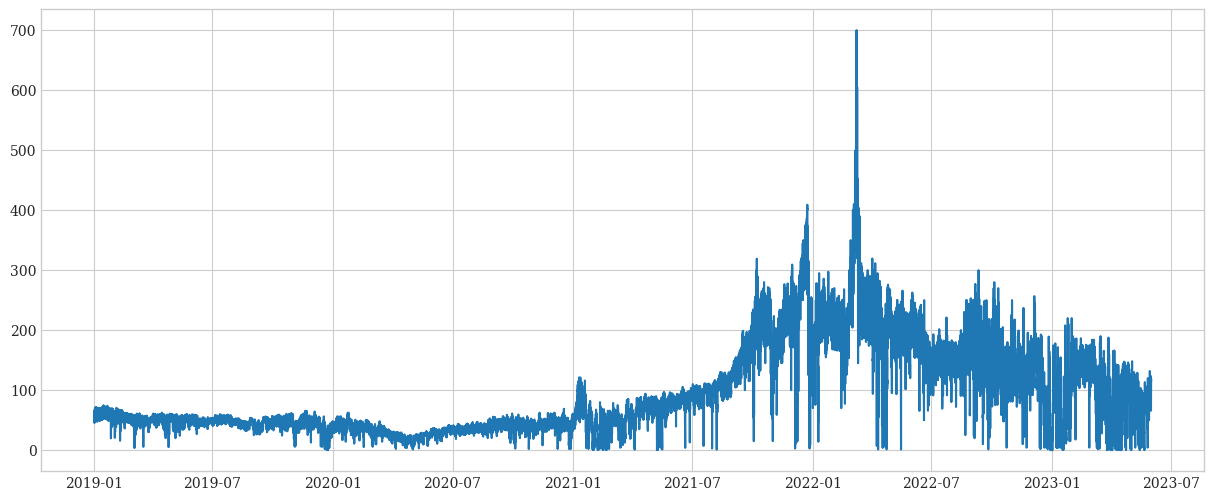

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)

In [11]:
df['Price_no_outliers'] = df.Price

Se añaden variables auxiliares

In [12]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_96'] = df.Price.shift(96)
df['Price_120'] = df.Price.shift(120)
df['Price_144'] = df.Price.shift(144)
df['Price_168'] = df.Price.shift(168)

In [13]:
df["diff_Price_24"] = df.Price - df.Price_24
df["lower_quantile_diff_Price_24"] = np.nan
df["upper_quantile_diff_Price_24"] = np.nan
for idx in range(len(df)):
    if idx >= 168:
        df_aux = df.loc[idx - 168 : idx - 1]
        df.loc[idx, "lower_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.025
        )
        df.loc[idx, "upper_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.975
        )

df["outlier"] = 0
df.loc[
    (df.diff_Price_24 < df.lower_quantile_diff_Price_24)
    | (df.diff_Price_24 > df.upper_quantile_diff_Price_24),
    "outlier",
] = 1

# df["Price_no_outliers"] = df["Price"]
col = df.loc[
    :,
    [
        "Price_24",
        "Price_48",
        "Price_72",
        "Price_96",
        "Price_120",
        "Price_144",
        "Price_168",
    ],
]
df["Price_median"] = col.median(axis=1)
df.loc[df.outlier == 1, "Price_no_outliers"] = df[
    df.outlier == 1
].Price_median

In [16]:
import matplotlib.colors as mcolors

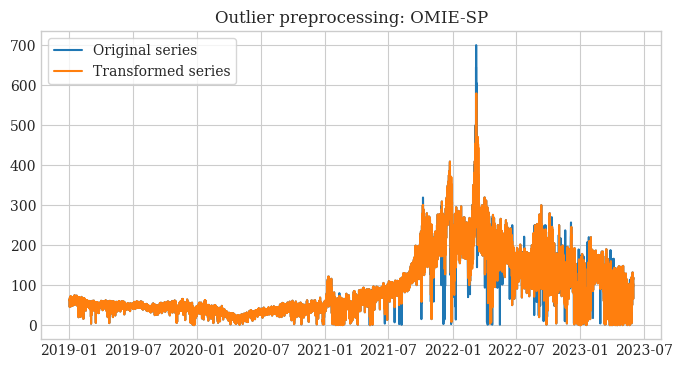

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(df.Date, df.Price, label='Original series')
ax.plot(df.Date, df.Price_no_outliers, label='Transformed series')
ax.legend(frameon=True)
ax.title.set_text('Outlier preprocessing: OMIE-SP')

In [26]:
fig.savefig('no_outlier_series.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [15]:
df = df[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']].rename(columns={'Price_no_outliers':'Price'})

In [16]:
df.index = df.Date

In [17]:
df = df.drop(['Date'], axis = 1)

In [18]:
df_train = df[df.index < dt.datetime(2022, 1, 1)]
df_test = df[df.index >= dt.datetime(2022, 1, 1)]

In [19]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [20]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [21]:
forecast_dates = forecast.index

In [22]:
from epftoolbox.models import LEAR

In [23]:
calibration_window = 2*364

In [24]:
model = LEAR(calibration_window=calibration_window)

In [25]:
df_original = pd.read_csv(r"Data\df_espana_final.csv")

In [26]:
df_original['Date'] = pd.to_datetime(df_original.Date)
df_original['Simple Date'] = df_original.Date.dt.strftime("%Y-%m-%d")
df_original['Hour'] = df_original.Date.dt.hour

In [27]:
df_original = df_original.fillna(0)

In [28]:
df_original.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Exogenous 4    0
Simple Date    0
Hour           0
dtype: int64

In [29]:
df_original

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3,Exogenous 4,Simple Date,Hour
0,2019-01-02 00:00:00,64.03,24914.0,5795.0,0.0,19.500,2019-01-02,0
1,2019-01-02 01:00:00,61.74,22758.0,6460.0,0.0,24.400,2019-01-02,1
2,2019-01-02 02:00:00,53.00,20772.0,6684.0,0.0,15.200,2019-01-02,2
3,2019-01-02 03:00:00,48.23,19690.0,6957.0,0.0,24.300,2019-01-02,3
4,2019-01-02 04:00:00,47.23,19176.0,7292.0,0.0,6.000,2019-01-02,4
...,...,...,...,...,...,...,...,...
38659,2023-05-31 19:00:00,78.89,25595.5,2325.8,8196.5,1413.275,2023-05-31,19
38660,2023-05-31 20:00:00,85.00,26170.3,2345.5,5498.0,1340.275,2023-05-31,20
38661,2023-05-31 21:00:00,105.00,26918.3,2253.3,1989.3,1021.550,2023-05-31,21
38662,2023-05-31 22:00:00,119.06,27557.3,2265.3,232.8,681.525,2023-05-31,22


In [30]:
df_original['Exogenous 2'] = df_original['Exogenous 2'] + df_original['Exogenous 3'] + df_original['Exogenous 4']
df_original = df_original.drop(['Exogenous 3', 'Exogenous 4'], axis = 1)

In [31]:
df_original.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [32]:
df_original.index = df_original.Date

In [33]:
df_original = df_original.drop('Date', axis = 1)

In [34]:
df_original = df_original.drop(['Simple Date', 'Hour'], axis = 1)

In [35]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [36]:
df_original = df_original[df_original.index >= dt.datetime(2022, 1, 1)]

In [37]:
real_values = df_original[df_original.index >= dt.datetime(2022, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [38]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,127.81,145.86,114.90,113.87,97.80,97.80,95.74,97.80,97.80,97.80,...,96.80,97.80,98.52,114.50,149.97,177.22,187.52,189.26,190.81,188.39
2022-01-02,167.26,133.21,115.87,110.52,113.00,115.87,110.52,115.87,129.60,115.87,...,110.52,115.87,109.50,115.87,159.79,194.25,198.00,208.38,209.10,191.36
2022-01-03,178.00,181.50,160.72,154.64,149.86,144.49,148.86,153.77,160.72,189.26,...,142.04,127.38,112.87,126.80,148.49,175.06,180.00,153.77,141.94,114.11
2022-01-04,100.36,125.47,115.55,113.29,105.81,105.00,115.11,153.77,161.03,178.91,...,179.59,163.20,157.30,157.30,163.78,184.94,178.99,156.12,148.65,137.92
2022-01-05,105.00,120.11,105.10,84.50,75.38,79.11,94.79,169.04,206.07,211.13,...,197.34,195.60,200.00,206.07,211.23,225.00,250.34,241.93,218.95,207.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,99.77,96.86,90.00,84.73,81.35,84.85,87.26,90.27,87.29,87.26,...,82.01,66.75,61.71,57.85,58.41,84.85,95.11,100.82,108.21,109.35
2023-05-28,110.00,105.42,100.00,99.37,100.00,100.00,100.00,97.85,90.42,83.06,...,70.47,69.57,54.17,50.00,51.00,55.00,73.28,100.01,109.08,115.38
2023-05-29,107.64,91.84,91.84,84.75,84.75,84.75,85.80,100.00,112.89,110.20,...,84.45,83.85,81.42,80.00,81.00,84.05,84.95,121.00,131.86,129.40


In [39]:
forecast_dates = forecast.index

In [41]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 44.00%  |  MAE: 62.859
2022-01-02 - sMAPE: 31.53%  |  MAE: 44.433
2022-01-03 - sMAPE: 25.71%  |  MAE: 37.251
2022-01-04 - sMAPE: 23.43%  |  MAE: 34.123
2022-01-05 - sMAPE: 23.21%  |  MAE: 34.551
2022-01-06 - sMAPE: 24.26%  |  MAE: 37.847
2022-01-07 - sMAPE: 22.23%  |  MAE: 35.339
2022-01-08 - sMAPE: 22.23%  |  MAE: 36.075
2022-01-09 - sMAPE: 24.60%  |  MAE: 37.183
2022-01-10 - sMAPE: 22.52%  |  MAE: 34.306
2022-01-11 - sMAPE: 21.04%  |  MAE: 32.366
2022-01-12 - sMAPE: 19.87%  |  MAE: 30.948
2022-01-13 - sMAPE: 19.30%  |  MAE: 30.840
2022-01-14 - sMAPE: 19.11%  |  MAE: 31.307
2022-01-15 - sMAPE: 18.51%  |  MAE: 30.633
2022-01-16 - sMAPE: 17.67%  |  MAE: 29.365
2022-01-17 - sMAPE: 16.96%  |  MAE: 28.485
2022-01-18 - sMAPE: 16.74%  |  MAE: 28.614
2022-01-19 - sMAPE: 16.12%  |  MAE: 27.652
2022-01-20 - sMAPE: 15.50%  |  MAE: 26.615
2022-01-21 - sMAPE: 15.02%  |  MAE: 25.759
2022-01-22 - sMAPE: 14.60%  |  MAE: 25.097
2022-01-23 - sMAPE: 14.11%  |  MAE: 24.297
2022-01-24 

2022-07-11 - sMAPE: 13.58%  |  MAE: 25.402
2022-07-12 - sMAPE: 13.55%  |  MAE: 25.335
2022-07-13 - sMAPE: 13.51%  |  MAE: 25.259
2022-07-14 - sMAPE: 13.49%  |  MAE: 25.200
2022-07-15 - sMAPE: 13.45%  |  MAE: 25.114
2022-07-16 - sMAPE: 13.45%  |  MAE: 25.080
2022-07-17 - sMAPE: 13.53%  |  MAE: 25.117
2022-07-18 - sMAPE: 13.51%  |  MAE: 25.054
2022-07-19 - sMAPE: 13.55%  |  MAE: 25.067
2022-07-20 - sMAPE: 13.52%  |  MAE: 25.002
2022-07-21 - sMAPE: 13.48%  |  MAE: 24.911
2022-07-22 - sMAPE: 13.45%  |  MAE: 24.833
2022-07-23 - sMAPE: 13.48%  |  MAE: 24.847
2022-07-24 - sMAPE: 13.47%  |  MAE: 24.806
2022-07-25 - sMAPE: 13.45%  |  MAE: 24.754
2022-07-26 - sMAPE: 13.42%  |  MAE: 24.677
2022-07-27 - sMAPE: 13.37%  |  MAE: 24.588
2022-07-28 - sMAPE: 13.36%  |  MAE: 24.550
2022-07-29 - sMAPE: 13.35%  |  MAE: 24.521
2022-07-30 - sMAPE: 13.33%  |  MAE: 24.457
2022-07-31 - sMAPE: 13.33%  |  MAE: 24.409
2022-08-01 - sMAPE: 13.30%  |  MAE: 24.351
2022-08-02 - sMAPE: 13.27%  |  MAE: 24.280
2022-08-03 

2023-01-18 - sMAPE: 20.08%  |  MAE: 23.801
2023-01-19 - sMAPE: 20.13%  |  MAE: 23.767
2023-01-20 - sMAPE: 20.20%  |  MAE: 23.798
2023-01-21 - sMAPE: 20.27%  |  MAE: 23.794
2023-01-22 - sMAPE: 20.45%  |  MAE: 23.782
2023-01-23 - sMAPE: 20.44%  |  MAE: 23.755
2023-01-24 - sMAPE: 20.42%  |  MAE: 23.735
2023-01-25 - sMAPE: 20.41%  |  MAE: 23.715
2023-01-26 - sMAPE: 20.43%  |  MAE: 23.711
2023-01-27 - sMAPE: 20.45%  |  MAE: 23.686
2023-01-28 - sMAPE: 20.47%  |  MAE: 23.658
2023-01-29 - sMAPE: 20.47%  |  MAE: 23.638
2023-01-30 - sMAPE: 20.54%  |  MAE: 23.708
2023-01-31 - sMAPE: 20.54%  |  MAE: 23.701
2023-02-01 - sMAPE: 20.52%  |  MAE: 23.683
2023-02-02 - sMAPE: 20.49%  |  MAE: 23.654
2023-02-03 - sMAPE: 20.45%  |  MAE: 23.617
2023-02-04 - sMAPE: 20.42%  |  MAE: 23.579
2023-02-05 - sMAPE: 20.48%  |  MAE: 23.582
2023-02-06 - sMAPE: 20.45%  |  MAE: 23.556
2023-02-07 - sMAPE: 20.42%  |  MAE: 23.518
2023-02-08 - sMAPE: 20.38%  |  MAE: 23.477
2023-02-09 - sMAPE: 20.34%  |  MAE: 23.439
2023-02-10 

In [42]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,185.530717,183.448456,163.205884,149.133198,150.55654,139.732789,146.311088,167.65965,177.279956,186.225965,...,178.355838,171.407053,165.330066,174.044414,202.214169,225.938445,238.266698,238.734097,230.251306,211.369799
2022-01-02,172.443351,155.200909,141.012866,136.556138,141.600251,140.542524,154.831716,154.115848,155.810708,158.261105,...,143.408465,137.788379,129.307075,139.890502,164.440734,179.529552,202.746488,223.027222,223.530716,209.8077
2022-01-03,177.018293,169.386777,155.293316,142.626219,142.159102,143.849107,146.937027,176.078991,188.524627,204.853839,...,156.519865,146.839041,154.104923,152.344226,167.941591,186.749,197.44176,211.508935,197.898114,172.572458
2022-01-04,164.637575,127.084236,113.14755,102.950802,100.661185,103.078191,106.006157,127.680169,148.375041,157.286592,...,135.166615,123.089509,120.218705,119.105963,130.884652,151.828121,150.76513,159.106808,161.918735,137.415696
2022-01-05,126.291099,124.250674,113.956772,111.099659,107.732914,103.016788,111.937221,122.673171,149.744032,159.030124,...,152.761644,154.033211,147.0592,160.724552,195.270684,215.046553,201.178679,195.143494,176.618115,171.043231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,106.640309,98.020424,90.758218,86.875935,85.047279,84.951929,87.629683,92.397272,100.575874,93.711368,...,57.148922,49.09364,50.237243,51.919766,66.827598,82.144776,104.296333,117.634555,125.692641,118.845068
2023-05-28,105.188745,102.591583,96.665352,92.701146,90.495657,88.523893,93.382864,96.586909,95.10401,94.112629,...,64.471971,58.197242,57.955813,58.472873,65.738343,85.163253,103.355232,118.490951,125.062694,120.8227
2023-05-29,105.685388,104.220776,97.745869,92.640589,90.955274,89.954817,94.533576,100.86532,105.434061,107.883785,...,74.86091,72.767526,60.19919,64.779095,72.520555,85.774111,107.485807,126.71739,125.162262,122.460852


In [43]:
forecast.to_csv("Resultados/espana_final_2_anos_ventana_no_outliers.csv")

In [40]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [41]:
forecast_dates = forecast.index

In [42]:
calibration_window = 1*364

In [43]:
model = LEAR(calibration_window=calibration_window)

In [44]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 46.52%  |  MAE: 66.864
2022-01-02 - sMAPE: 39.18%  |  MAE: 58.014
2022-01-03 - sMAPE: 29.59%  |  MAE: 44.062
2022-01-04 - sMAPE: 27.42%  |  MAE: 40.685
2022-01-05 - sMAPE: 27.52%  |  MAE: 41.544
2022-01-06 - sMAPE: 27.59%  |  MAE: 43.254
2022-01-07 - sMAPE: 25.27%  |  MAE: 40.292
2022-01-08 - sMAPE: 24.69%  |  MAE: 40.065
2022-01-09 - sMAPE: 27.61%  |  MAE: 42.107
2022-01-10 - sMAPE: 25.40%  |  MAE: 39.114
2022-01-11 - sMAPE: 23.65%  |  MAE: 36.725
2022-01-12 - sMAPE: 22.23%  |  MAE: 34.829
2022-01-13 - sMAPE: 21.37%  |  MAE: 34.099
2022-01-14 - sMAPE: 20.91%  |  MAE: 34.066
2022-01-15 - sMAPE: 19.98%  |  MAE: 32.770
2022-01-16 - sMAPE: 18.91%  |  MAE: 31.102
2022-01-17 - sMAPE: 17.99%  |  MAE: 29.747
2022-01-18 - sMAPE: 17.54%  |  MAE: 29.374
2022-01-19 - sMAPE: 17.18%  |  MAE: 29.089
2022-01-20 - sMAPE: 16.64%  |  MAE: 28.231
2022-01-21 - sMAPE: 16.06%  |  MAE: 27.294
2022-01-22 - sMAPE: 15.52%  |  MAE: 26.426
2022-01-23 - sMAPE: 14.93%  |  MAE: 25.456
2022-01-24 

2022-07-11 - sMAPE: 13.86%  |  MAE: 25.570
2022-07-12 - sMAPE: 13.83%  |  MAE: 25.498
2022-07-13 - sMAPE: 13.79%  |  MAE: 25.432
2022-07-14 - sMAPE: 13.75%  |  MAE: 25.345
2022-07-15 - sMAPE: 13.73%  |  MAE: 25.286
2022-07-16 - sMAPE: 13.72%  |  MAE: 25.248
2022-07-17 - sMAPE: 13.80%  |  MAE: 25.279
2022-07-18 - sMAPE: 13.80%  |  MAE: 25.240
2022-07-19 - sMAPE: 13.81%  |  MAE: 25.221
2022-07-20 - sMAPE: 13.78%  |  MAE: 25.149
2022-07-21 - sMAPE: 13.74%  |  MAE: 25.065
2022-07-22 - sMAPE: 13.71%  |  MAE: 24.992
2022-07-23 - sMAPE: 13.73%  |  MAE: 24.989
2022-07-24 - sMAPE: 13.72%  |  MAE: 24.948
2022-07-25 - sMAPE: 13.69%  |  MAE: 24.884
2022-07-26 - sMAPE: 13.66%  |  MAE: 24.810
2022-07-27 - sMAPE: 13.62%  |  MAE: 24.729
2022-07-28 - sMAPE: 13.59%  |  MAE: 24.681
2022-07-29 - sMAPE: 13.59%  |  MAE: 24.655
2022-07-30 - sMAPE: 13.57%  |  MAE: 24.600
2022-07-31 - sMAPE: 13.57%  |  MAE: 24.550
2022-08-01 - sMAPE: 13.53%  |  MAE: 24.475
2022-08-02 - sMAPE: 13.49%  |  MAE: 24.397
2022-08-03 

2023-01-18 - sMAPE: 20.34%  |  MAE: 24.252
2023-01-19 - sMAPE: 20.43%  |  MAE: 24.224
2023-01-20 - sMAPE: 20.51%  |  MAE: 24.241
2023-01-21 - sMAPE: 20.54%  |  MAE: 24.219
2023-01-22 - sMAPE: 20.78%  |  MAE: 24.236
2023-01-23 - sMAPE: 20.77%  |  MAE: 24.203
2023-01-24 - sMAPE: 20.76%  |  MAE: 24.179
2023-01-25 - sMAPE: 20.74%  |  MAE: 24.154
2023-01-26 - sMAPE: 20.75%  |  MAE: 24.146
2023-01-27 - sMAPE: 20.81%  |  MAE: 24.143
2023-01-28 - sMAPE: 20.81%  |  MAE: 24.107
2023-01-29 - sMAPE: 20.85%  |  MAE: 24.092
2023-01-30 - sMAPE: 20.89%  |  MAE: 24.141
2023-01-31 - sMAPE: 20.90%  |  MAE: 24.144
2023-02-01 - sMAPE: 20.87%  |  MAE: 24.107
2023-02-02 - sMAPE: 20.84%  |  MAE: 24.075
2023-02-03 - sMAPE: 20.80%  |  MAE: 24.037
2023-02-04 - sMAPE: 20.77%  |  MAE: 24.001
2023-02-05 - sMAPE: 20.82%  |  MAE: 24.005
2023-02-06 - sMAPE: 20.79%  |  MAE: 23.972
2023-02-07 - sMAPE: 20.76%  |  MAE: 23.933
2023-02-08 - sMAPE: 20.72%  |  MAE: 23.895
2023-02-09 - sMAPE: 20.68%  |  MAE: 23.857
2023-02-10 

In [45]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,183.16176,196.947459,173.684502,182.029769,173.289884,160.987335,169.554853,172.647331,194.120336,212.982135,...,168.585267,168.347234,173.521372,175.110208,198.314722,212.383051,228.610823,228.234316,231.312562,207.567572
2022-01-02,169.371552,188.294908,237.11646,268.684045,155.204988,170.106338,149.566596,198.276981,192.70462,206.487961,...,163.782426,146.749495,159.698263,156.06075,164.764998,171.824017,205.678726,231.803546,213.779989,200.80968
2022-01-03,172.426387,150.832551,165.215534,160.589598,166.340043,161.357742,156.50229,161.498933,185.763658,186.56205,...,150.038154,139.71573,141.989737,143.084875,155.539341,173.576871,191.361781,191.646396,184.733515,167.97595
2022-01-04,169.574454,129.481969,136.830216,135.634193,123.341889,129.913061,122.765013,139.973135,169.227131,144.008478,...,123.800267,117.903207,123.217086,113.786546,129.791181,147.504243,150.346227,157.582989,161.373943,151.580882
2022-01-05,126.833758,125.282587,114.665594,117.770915,116.230223,112.413632,114.150767,118.644872,143.527381,158.346213,...,148.372257,133.656878,125.732743,147.220707,177.411893,193.516801,192.287892,182.011024,163.794113,154.942076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,108.263316,98.821053,91.094889,86.733002,85.431704,85.467767,89.167337,94.891059,102.80032,101.334696,...,64.777514,58.170706,56.332889,59.948647,74.194986,91.746134,110.279472,123.933074,123.976688,114.984122
2023-05-28,102.507606,106.43775,101.446727,94.798486,93.820136,91.821064,97.915342,101.704038,100.788453,103.965384,...,63.567009,60.330315,62.863326,65.315187,76.531639,90.343861,110.26772,122.803965,126.633782,118.555091
2023-05-29,103.241932,108.680168,103.752078,97.354763,95.762977,91.481509,100.03725,109.067124,116.950901,121.516129,...,79.184518,77.491827,68.643497,67.384338,78.619016,98.497401,114.334026,129.610097,132.700307,127.764283


In [46]:
forecast.to_csv("Resultados/espana_final_1_ano_ventana_no_outliers.csv")

In [47]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [48]:
forecast_dates = forecast.index

In [49]:
calibration_window = 182

In [50]:
model = LEAR(calibration_window=calibration_window)

In [51]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 48.85%  |  MAE: 71.781
2022-01-02 - sMAPE: 36.45%  |  MAE: 53.315
2022-01-03 - sMAPE: 30.92%  |  MAE: 44.739
2022-01-04 - sMAPE: 27.88%  |  MAE: 40.361
2022-01-05 - sMAPE: 28.32%  |  MAE: 41.777
2022-01-06 - sMAPE: 26.96%  |  MAE: 41.143
2022-01-07 - sMAPE: 24.26%  |  MAE: 37.892
2022-01-08 - sMAPE: 22.59%  |  MAE: 35.871
2022-01-09 - sMAPE: 26.52%  |  MAE: 39.942
2022-01-10 - sMAPE: 24.46%  |  MAE: 37.259
2022-01-11 - sMAPE: 22.83%  |  MAE: 35.129
2022-01-12 - sMAPE: 21.75%  |  MAE: 34.024
2022-01-13 - sMAPE: 20.74%  |  MAE: 32.901
2022-01-14 - sMAPE: 20.29%  |  MAE: 32.867
2022-01-15 - sMAPE: 19.18%  |  MAE: 31.208
2022-01-16 - sMAPE: 18.20%  |  MAE: 29.725
2022-01-17 - sMAPE: 17.32%  |  MAE: 28.434
2022-01-18 - sMAPE: 16.79%  |  MAE: 27.881
2022-01-19 - sMAPE: 16.58%  |  MAE: 27.905
2022-01-20 - sMAPE: 16.21%  |  MAE: 27.423
2022-01-21 - sMAPE: 15.79%  |  MAE: 26.770
2022-01-22 - sMAPE: 15.23%  |  MAE: 25.856
2022-01-23 - sMAPE: 14.74%  |  MAE: 25.077
2022-01-24 

2022-07-11 - sMAPE: 13.83%  |  MAE: 25.923
2022-07-12 - sMAPE: 13.80%  |  MAE: 25.866
2022-07-13 - sMAPE: 13.76%  |  MAE: 25.782
2022-07-14 - sMAPE: 13.72%  |  MAE: 25.692
2022-07-15 - sMAPE: 13.71%  |  MAE: 25.652
2022-07-16 - sMAPE: 13.69%  |  MAE: 25.592
2022-07-17 - sMAPE: 13.78%  |  MAE: 25.637
2022-07-18 - sMAPE: 13.79%  |  MAE: 25.612
2022-07-19 - sMAPE: 13.82%  |  MAE: 25.609
2022-07-20 - sMAPE: 13.80%  |  MAE: 25.540
2022-07-21 - sMAPE: 13.76%  |  MAE: 25.464
2022-07-22 - sMAPE: 13.73%  |  MAE: 25.391
2022-07-23 - sMAPE: 13.75%  |  MAE: 25.382
2022-07-24 - sMAPE: 13.75%  |  MAE: 25.353
2022-07-25 - sMAPE: 13.72%  |  MAE: 25.287
2022-07-26 - sMAPE: 13.70%  |  MAE: 25.231
2022-07-27 - sMAPE: 13.67%  |  MAE: 25.159
2022-07-28 - sMAPE: 13.65%  |  MAE: 25.110
2022-07-29 - sMAPE: 13.65%  |  MAE: 25.102
2022-07-30 - sMAPE: 13.64%  |  MAE: 25.051
2022-07-31 - sMAPE: 13.65%  |  MAE: 25.017
2022-08-01 - sMAPE: 13.62%  |  MAE: 24.944
2022-08-02 - sMAPE: 13.57%  |  MAE: 24.855
2022-08-03 

2023-01-18 - sMAPE: 20.73%  |  MAE: 24.834
2023-01-19 - sMAPE: 20.83%  |  MAE: 24.819
2023-01-20 - sMAPE: 20.87%  |  MAE: 24.820
2023-01-21 - sMAPE: 20.88%  |  MAE: 24.795
2023-01-22 - sMAPE: 21.04%  |  MAE: 24.797
2023-01-23 - sMAPE: 21.02%  |  MAE: 24.766
2023-01-24 - sMAPE: 21.01%  |  MAE: 24.740
2023-01-25 - sMAPE: 20.99%  |  MAE: 24.715
2023-01-26 - sMAPE: 20.98%  |  MAE: 24.685
2023-01-27 - sMAPE: 21.02%  |  MAE: 24.669
2023-01-28 - sMAPE: 21.03%  |  MAE: 24.635
2023-01-29 - sMAPE: 21.03%  |  MAE: 24.617
2023-01-30 - sMAPE: 21.09%  |  MAE: 24.670
2023-01-31 - sMAPE: 21.11%  |  MAE: 24.687
2023-02-01 - sMAPE: 21.09%  |  MAE: 24.662
2023-02-02 - sMAPE: 21.07%  |  MAE: 24.646
2023-02-03 - sMAPE: 21.04%  |  MAE: 24.610
2023-02-04 - sMAPE: 21.00%  |  MAE: 24.575
2023-02-05 - sMAPE: 21.06%  |  MAE: 24.577
2023-02-06 - sMAPE: 21.04%  |  MAE: 24.561
2023-02-07 - sMAPE: 21.01%  |  MAE: 24.528
2023-02-08 - sMAPE: 20.97%  |  MAE: 24.487
2023-02-09 - sMAPE: 20.95%  |  MAE: 24.458
2023-02-10 

In [52]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,198.085113,184.050926,172.566868,196.730158,187.100301,167.655252,190.236335,180.298453,203.907582,224.600966,...,184.05853,170.571424,172.675827,171.510717,194.326364,209.438305,221.190933,243.320725,245.935812,206.520899
2022-01-02,170.105694,156.980161,164.313399,164.195204,156.039482,145.78953,156.207671,123.217165,142.054399,189.429342,...,152.465273,155.062494,149.498243,157.789932,147.982445,168.777123,204.866305,255.090385,241.097064,172.77793
2022-01-03,175.726689,143.77776,112.278269,97.107404,87.130128,103.06338,107.317009,128.230543,154.031539,175.354254,...,137.263688,137.844472,131.754142,147.163741,149.469643,178.191712,194.084419,183.086592,186.041531,146.337466
2022-01-04,172.64055,134.840129,149.022705,121.393902,133.871808,155.798562,158.582727,176.414179,185.108426,174.911769,...,125.484415,117.313867,124.317066,116.192346,151.948821,165.809797,175.034425,160.835679,163.256491,142.067263
2022-01-05,126.030842,110.914761,81.437283,103.648691,99.423602,103.868826,131.077369,123.999262,146.81442,152.303629,...,125.020106,127.020881,108.650256,141.430116,178.501376,203.291532,202.156753,194.070767,164.173355,156.228021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,103.141173,99.056956,91.144291,84.381741,82.294971,81.069782,86.502014,94.057519,104.7762,103.128308,...,45.486763,41.111539,34.540389,34.128502,44.047861,73.5833,102.184149,121.177174,124.228301,116.067279
2023-05-28,102.700847,96.79405,94.829201,89.990967,88.165415,86.207113,93.637311,97.423869,100.452721,99.152777,...,54.235374,49.70492,46.6077,42.762617,56.127873,79.287767,101.041006,114.122877,119.760216,115.548389
2023-05-29,108.416334,101.146873,99.218328,93.926601,90.454288,89.079532,97.766792,103.672104,107.338005,115.862869,...,72.43655,66.073547,65.906632,64.789627,78.355944,94.100951,107.057989,117.108249,120.127394,118.148334


In [53]:
forecast.to_csv("Resultados/espana_final_6_meses_ventana_no_outliers.csv")

# Estandarización móvil + LEAR + No outliers

In [54]:
df = pd.read_csv(r"Data/df_espana_final.csv")

In [55]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [56]:
df = df.fillna(0)

In [57]:
df.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Exogenous 4    0
Simple Date    0
Hour           0
dtype: int64

In [58]:
df

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3,Exogenous 4,Simple Date,Hour
0,2019-01-02 00:00:00,64.03,24914.0,5795.0,0.0,19.500,2019-01-02,0
1,2019-01-02 01:00:00,61.74,22758.0,6460.0,0.0,24.400,2019-01-02,1
2,2019-01-02 02:00:00,53.00,20772.0,6684.0,0.0,15.200,2019-01-02,2
3,2019-01-02 03:00:00,48.23,19690.0,6957.0,0.0,24.300,2019-01-02,3
4,2019-01-02 04:00:00,47.23,19176.0,7292.0,0.0,6.000,2019-01-02,4
...,...,...,...,...,...,...,...,...
38659,2023-05-31 19:00:00,78.89,25595.5,2325.8,8196.5,1413.275,2023-05-31,19
38660,2023-05-31 20:00:00,85.00,26170.3,2345.5,5498.0,1340.275,2023-05-31,20
38661,2023-05-31 21:00:00,105.00,26918.3,2253.3,1989.3,1021.550,2023-05-31,21
38662,2023-05-31 22:00:00,119.06,27557.3,2265.3,232.8,681.525,2023-05-31,22


In [59]:
df['Exogenous 2'] = df['Exogenous 2'] + df['Exogenous 3'] + df['Exogenous 4']
df = df.drop(['Exogenous 3', 'Exogenous 4'], axis = 1)

In [60]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [61]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2019-01-02 00:00:00,64.03,24914.0,5814.500,2019-01-02,0
1,2019-01-02 01:00:00,61.74,22758.0,6484.400,2019-01-02,1
2,2019-01-02 02:00:00,53.00,20772.0,6699.200,2019-01-02,2
3,2019-01-02 03:00:00,48.23,19690.0,6981.300,2019-01-02,3
4,2019-01-02 04:00:00,47.23,19176.0,7298.000,2019-01-02,4
...,...,...,...,...,...,...
38659,2023-05-31 19:00:00,78.89,25595.5,11935.575,2023-05-31,19
38660,2023-05-31 20:00:00,85.00,26170.3,9183.775,2023-05-31,20
38661,2023-05-31 21:00:00,105.00,26918.3,5264.150,2023-05-31,21
38662,2023-05-31 22:00:00,119.06,27557.3,3179.625,2023-05-31,22


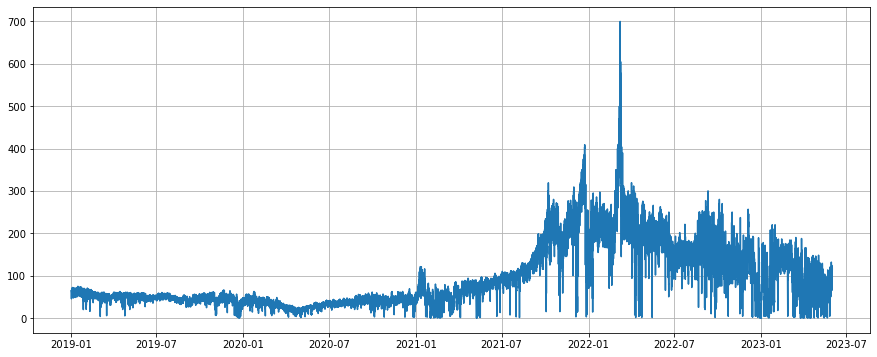

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

In [63]:
df['Price_no_outliers'] = df.Price

Se añaden variables auxiliares

In [64]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_96'] = df.Price.shift(96)
df['Price_120'] = df.Price.shift(120)
df['Price_144'] = df.Price.shift(144)
df['Price_168'] = df.Price.shift(168)

In [65]:
df["diff_Price_24"] = df.Price - df.Price_24
df["lower_quantile_diff_Price_24"] = np.nan
df["upper_quantile_diff_Price_24"] = np.nan
for idx in range(len(df)):
    if idx >= 168:
        df_aux = df.loc[idx - 168 : idx - 1]
        df.loc[idx, "lower_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.025
        )
        df.loc[idx, "upper_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.975
        )

df["outlier"] = 0
df.loc[
    (df.diff_Price_24 < df.lower_quantile_diff_Price_24)
    | (df.diff_Price_24 > df.upper_quantile_diff_Price_24),
    "outlier",
] = 1

# df["Price_no_outliers"] = df["Price"]
col = df.loc[
    :,
    [
        "Price_24",
        "Price_48",
        "Price_72",
        "Price_96",
        "Price_120",
        "Price_144",
        "Price_168",
    ],
]
df["Price_median"] = col.median(axis=1)
df.loc[df.outlier == 1, "Price_no_outliers"] = df[
    df.outlier == 1
].Price_median

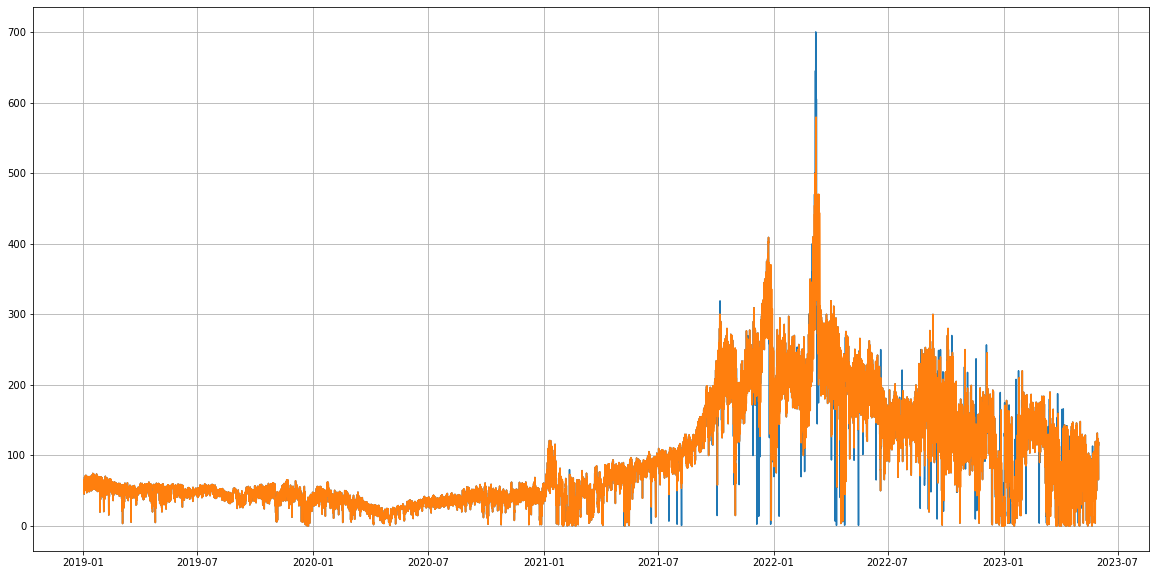

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(df.Date, df.Price)
ax.plot(df.Date, df.Price_no_outliers)
ax.grid()

In [67]:
df = df[['Date', 'Price', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']]

In [68]:
df.index = df.Date

In [69]:
df = df.drop(['Date'], axis = 1)

In [70]:
# names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# for i, x in enumerate(names):
#     df[x] = (pd.to_datetime(df['Simple Date']).dt.weekday == i).astype(int)

In [71]:
# for hora in range(24):
#     df['Price_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Price_hora = df_fecha[df_fecha.Hour == hora].Price.values[0]
        
#         df.loc[df_fecha.index, 'Price_hora_'+str(hora)] = Price_hora

In [72]:
# for col in ['Price_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
#     df[col+"_"+str(48)] = df[col].shift(48)
#     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [73]:
# for hora in range(24):
#     df['Exogenous 1_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_1_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 1'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 1_hora_'+str(hora)] = Exogenous_1_hora

In [74]:
# for hora in range(24):
#     df['Exogenous 2_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_2_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 2'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 2_hora_'+str(hora)] = Exogenous_2_hora

In [75]:
# for col in ['Exogenous 1_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)
# for col in ['Exogenous 2_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [76]:
# list(df.columns)

In [82]:
df

,Price,Price_no_outliers,Exogenous 1,Exogenous 2,Simple Date,Hour,Date
Date,,,,,,,
2019-01-02 00:00:00,64.03,64.03,24914.0,5814.500,2019-01-02,0,2019-01-02 00:00:00
2019-01-02 01:00:00,61.74,61.74,22758.0,6484.400,2019-01-02,1,2019-01-02 01:00:00
2019-01-02 02:00:00,53.00,53.00,20772.0,6699.200,2019-01-02,2,2019-01-02 02:00:00
2019-01-02 03:00:00,48.23,48.23,19690.0,6981.300,2019-01-02,3,2019-01-02 03:00:00
2019-01-02 04:00:00,47.23,47.23,19176.0,7298.000,2019-01-02,4,2019-01-02 04:00:00
...,...,...,...,...,...,...,...
2023-05-31 19:00:00,78.89,78.89,25595.5,11935.575,2023-05-31,19,2023-05-31 19:00:00
2023-05-31 20:00:00,85.00,85.00,26170.3,9183.775,2023-05-31,20,2023-05-31 20:00:00
2023-05-31 21:00:00,105.00,105.00,26918.3,5264.150,2023-05-31,21,2023-05-31 21:00:00


In [81]:
df['Date'] = df.index

In [84]:
df = df.reset_index(drop=True)

In [85]:
columnas = ['Date',
 'Price',
 'Price_no_outliers',
 'Exogenous 1',
 'Exogenous 2',
 'Simple Date',
 'Hour',
#  'Price_24',
#  'Price_48',
#  'Price_72',
#  'Price_168',
#  'Price_hora_0',
#  'Price_hora_1',
#  'Price_hora_2',
#  'Price_hora_3',
#  'Price_hora_4',
#  'Price_hora_5',
#  'Price_hora_6',
#  'Price_hora_7',
#  'Price_hora_8',
#  'Price_hora_9',
#  'Price_hora_10',
#  'Price_hora_11',
#  'Price_hora_12',
#  'Price_hora_13',
#  'Price_hora_14',
#  'Price_hora_15',
#  'Price_hora_16',
#  'Price_hora_17',
#  'Price_hora_18',
#  'Price_hora_19',
#  'Price_hora_20',
#  'Price_hora_21',
#  'Price_hora_22',
#  'Price_hora_23',
#  'Price_hora_0_24',
#  'Price_hora_0_48',
#  'Price_hora_0_72',
#  'Price_hora_0_168',
#  'Price_hora_1_24',
#  'Price_hora_1_48',
#  'Price_hora_1_72',
#  'Price_hora_1_168',
#  'Price_hora_2_24',
#  'Price_hora_2_48',
#  'Price_hora_2_72',
#  'Price_hora_2_168',
#  'Price_hora_3_24',
#  'Price_hora_3_48',
#  'Price_hora_3_72',
#  'Price_hora_3_168',
#  'Price_hora_4_24',
#  'Price_hora_4_48',
#  'Price_hora_4_72',
#  'Price_hora_4_168',
#  'Price_hora_5_24',
#  'Price_hora_5_48',
#  'Price_hora_5_72',
#  'Price_hora_5_168',
#  'Price_hora_6_24',
#  'Price_hora_6_48',
#  'Price_hora_6_72',
#  'Price_hora_6_168',
#  'Price_hora_7_24',
#  'Price_hora_7_48',
#  'Price_hora_7_72',
#  'Price_hora_7_168',
#  'Price_hora_8_24',
#  'Price_hora_8_48',
#  'Price_hora_8_72',
#  'Price_hora_8_168',
#  'Price_hora_9_24',
#  'Price_hora_9_48',
#  'Price_hora_9_72',
#  'Price_hora_9_168',
#  'Price_hora_10_24',
#  'Price_hora_10_48',
#  'Price_hora_10_72',
#  'Price_hora_10_168',
#  'Price_hora_11_24',
#  'Price_hora_11_48',
#  'Price_hora_11_72',
#  'Price_hora_11_168',
#  'Price_hora_12_24',
#  'Price_hora_12_48',
#  'Price_hora_12_72',
#  'Price_hora_12_168',
#  'Price_hora_13_24',
#  'Price_hora_13_48',
#  'Price_hora_13_72',
#  'Price_hora_13_168',
#  'Price_hora_14_24',
#  'Price_hora_14_48',
#  'Price_hora_14_72',
#  'Price_hora_14_168',
#  'Price_hora_15_24',
#  'Price_hora_15_48',
#  'Price_hora_15_72',
#  'Price_hora_15_168',
#  'Price_hora_16_24',
#  'Price_hora_16_48',
#  'Price_hora_16_72',
#  'Price_hora_16_168',
#  'Price_hora_17_24',
#  'Price_hora_17_48',
#  'Price_hora_17_72',
#  'Price_hora_17_168',
#  'Price_hora_18_24',
#  'Price_hora_18_48',
#  'Price_hora_18_72',
#  'Price_hora_18_168',
#  'Price_hora_19_24',
#  'Price_hora_19_48',
#  'Price_hora_19_72',
#  'Price_hora_19_168',
#  'Price_hora_20_24',
#  'Price_hora_20_48',
#  'Price_hora_20_72',
#  'Price_hora_20_168',
#  'Price_hora_21_24',
#  'Price_hora_21_48',
#  'Price_hora_21_72',
#  'Price_hora_21_168',
#  'Price_hora_22_24',
#  'Price_hora_22_48',
#  'Price_hora_22_72',
#  'Price_hora_22_168',
#  'Price_hora_23_24',
#  'Price_hora_23_48',
#  'Price_hora_23_72',
#  'Price_hora_23_168',
#  'Exogenous 1_hora_0',
#  'Exogenous 1_hora_1',
#  'Exogenous 1_hora_2',
#  'Exogenous 1_hora_3',
#  'Exogenous 1_hora_4',
#  'Exogenous 1_hora_5',
#  'Exogenous 1_hora_6',
#  'Exogenous 1_hora_7',
#  'Exogenous 1_hora_8',
#  'Exogenous 1_hora_9',
#  'Exogenous 1_hora_10',
#  'Exogenous 1_hora_11',
#  'Exogenous 1_hora_12',
#  'Exogenous 1_hora_13',
#  'Exogenous 1_hora_14',
#  'Exogenous 1_hora_15',
#  'Exogenous 1_hora_16',
#  'Exogenous 1_hora_17',
#  'Exogenous 1_hora_18',
#  'Exogenous 1_hora_19',
#  'Exogenous 1_hora_20',
#  'Exogenous 1_hora_21',
#  'Exogenous 1_hora_22',
#  'Exogenous 1_hora_23',
#  'Exogenous 2_hora_0',
#  'Exogenous 2_hora_1',
#  'Exogenous 2_hora_2',
#  'Exogenous 2_hora_3',
#  'Exogenous 2_hora_4',
#  'Exogenous 2_hora_5',
#  'Exogenous 2_hora_6',
#  'Exogenous 2_hora_7',
#  'Exogenous 2_hora_8',
#  'Exogenous 2_hora_9',
#  'Exogenous 2_hora_10',
#  'Exogenous 2_hora_11',
#  'Exogenous 2_hora_12',
#  'Exogenous 2_hora_13',
#  'Exogenous 2_hora_14',
#  'Exogenous 2_hora_15',
#  'Exogenous 2_hora_16',
#  'Exogenous 2_hora_17',
#  'Exogenous 2_hora_18',
#  'Exogenous 2_hora_19',
#  'Exogenous 2_hora_20',
#  'Exogenous 2_hora_21',
#  'Exogenous 2_hora_22',
#  'Exogenous 2_hora_23',
#  'Exogenous 1_hora_0_24',
#  'Exogenous 1_hora_0_168',
#  'Exogenous 1_hora_1_24',
#  'Exogenous 1_hora_1_168',
#  'Exogenous 1_hora_2_24',
#  'Exogenous 1_hora_2_168',
#  'Exogenous 1_hora_3_24',
#  'Exogenous 1_hora_3_168',
#  'Exogenous 1_hora_4_24',
#  'Exogenous 1_hora_4_168',
#  'Exogenous 1_hora_5_24',
#  'Exogenous 1_hora_5_168',
#  'Exogenous 1_hora_6_24',
#  'Exogenous 1_hora_6_168',
#  'Exogenous 1_hora_7_24',
#  'Exogenous 1_hora_7_168',
#  'Exogenous 1_hora_8_24',
#  'Exogenous 1_hora_8_168',
#  'Exogenous 1_hora_9_24',
#  'Exogenous 1_hora_9_168',
#  'Exogenous 1_hora_10_24',
#  'Exogenous 1_hora_10_168',
#  'Exogenous 1_hora_11_24',
#  'Exogenous 1_hora_11_168',
#  'Exogenous 1_hora_12_24',
#  'Exogenous 1_hora_12_168',
#  'Exogenous 1_hora_13_24',
#  'Exogenous 1_hora_13_168',
#  'Exogenous 1_hora_14_24',
#  'Exogenous 1_hora_14_168',
#  'Exogenous 1_hora_15_24',
#  'Exogenous 1_hora_15_168',
#  'Exogenous 1_hora_16_24',
#  'Exogenous 1_hora_16_168',
#  'Exogenous 1_hora_17_24',
#  'Exogenous 1_hora_17_168',
#  'Exogenous 1_hora_18_24',
#  'Exogenous 1_hora_18_168',
#  'Exogenous 1_hora_19_24',
#  'Exogenous 1_hora_19_168',
#  'Exogenous 1_hora_20_24',
#  'Exogenous 1_hora_20_168',
#  'Exogenous 1_hora_21_24',
#  'Exogenous 1_hora_21_168',
#  'Exogenous 1_hora_22_24',
#  'Exogenous 1_hora_22_168',
#  'Exogenous 1_hora_23_24',
#  'Exogenous 1_hora_23_168',
#  'Exogenous 2_hora_0_24',
#  'Exogenous 2_hora_0_168',
#  'Exogenous 2_hora_1_24',
#  'Exogenous 2_hora_1_168',
#  'Exogenous 2_hora_2_24',
#  'Exogenous 2_hora_2_168',
#  'Exogenous 2_hora_3_24',
#  'Exogenous 2_hora_3_168',
#  'Exogenous 2_hora_4_24',
#  'Exogenous 2_hora_4_168',
#  'Exogenous 2_hora_5_24',
#  'Exogenous 2_hora_5_168',
#  'Exogenous 2_hora_6_24',
#  'Exogenous 2_hora_6_168',
#  'Exogenous 2_hora_7_24',
#  'Exogenous 2_hora_7_168',
#  'Exogenous 2_hora_8_24',
#  'Exogenous 2_hora_8_168',
#  'Exogenous 2_hora_9_24',
#  'Exogenous 2_hora_9_168',
#  'Exogenous 2_hora_10_24',
#  'Exogenous 2_hora_10_168',
#  'Exogenous 2_hora_11_24',
#  'Exogenous 2_hora_11_168',
#  'Exogenous 2_hora_12_24',
#  'Exogenous 2_hora_12_168',
#  'Exogenous 2_hora_13_24',
#  'Exogenous 2_hora_13_168',
#  'Exogenous 2_hora_14_24',
#  'Exogenous 2_hora_14_168',
#  'Exogenous 2_hora_15_24',
#  'Exogenous 2_hora_15_168',
#  'Exogenous 2_hora_16_24',
#  'Exogenous 2_hora_16_168',
#  'Exogenous 2_hora_17_24',
#  'Exogenous 2_hora_17_168',
#  'Exogenous 2_hora_18_24',
#  'Exogenous 2_hora_18_168',
#  'Exogenous 2_hora_19_24',
#  'Exogenous 2_hora_19_168',
#  'Exogenous 2_hora_20_24',
#  'Exogenous 2_hora_20_168',
#  'Exogenous 2_hora_21_24',
#  'Exogenous 2_hora_21_168',
#  'Exogenous 2_hora_22_24',
#  'Exogenous 2_hora_22_168',
#  'Exogenous 2_hora_23_24',
#  'Exogenous 2_hora_23_168'
           ]

# columnas_post = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
#        'Saturday', 'Sunday']

In [86]:
def standard_movil(df):
    columnas = list(df.columns)
    dict_new_df = {col: [] for col in columnas}
    columnas.remove('Date')
    columnas.remove('Simple Date')
    columnas.remove('Hour')
    dict_new_df['scaler'] = []
    dict_new_df['Price_real'] = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        if index >= 168*1:
            dict_new_df['Date'].append(row.Date)
            dict_new_df['Simple Date'].append(row['Simple Date'])
            dict_new_df['Hour'].append(row.Hour)
            df_aux = df[(pd.to_datetime(df['Simple Date']) < pd.to_datetime(row['Simple Date'])) & (pd.to_datetime(df['Simple Date']) >= pd.to_datetime(row['Simple Date']) - dt.timedelta(days=7))]
            for col in columnas:
                df_aux_col = df_aux[col].to_numpy().reshape(-1, 1)
                scaler = StandardScaler()
                scaler.fit(df_aux_col)
                if col == 'Price':
                    dict_new_df['Price_real'].append(row[col])
#                     if np.abs(scaler.transform(np.array(row[col]).reshape(1, -1))[0][0]) > 5:
#                         scaler.scale_ =  np.abs((row[col] - scaler.mean_)/5)
                elif col == 'Price_no_outliers':
                    dict_new_df['scaler'].append(scaler)
                dict_new_df[col].append(scaler.transform(np.array(row[col]).reshape(1, -1))[0][0])
    return dict_new_df

In [87]:
dict_new_df = standard_movil(df[columnas])

100%|████████████████████████████████████████████████████████████████████████████| 38664/38664 [08:17<00:00, 77.67it/s]


In [88]:
df = df.drop(df.head(168).index)

In [89]:
with open('dict_new_df_espana_final_no_outliers.pkl', 'wb') as f:
    pickle.dump(dict_new_df, f)

In [90]:
# df = df.drop(df.head(168).index)

In [91]:
# with open('dict_new_df_be_epftoolbox_final_no_outliers.pkl', 'rb') as handle:
#     dict_new_df = pickle.load(handle)

In [92]:
for k, v in dict_new_df.items():
    print(k, len(v))

Date 38496
Price 38496
Price_no_outliers 38496
Exogenous 1 38496
Exogenous 2 38496
Simple Date 38496
Hour 38496
scaler 38496
Price_real 38496


In [93]:
df_nuevo = pd.DataFrame(dict_new_df)

In [94]:
# for col in columnas_post:
#     df_nuevo[col] = df[col].to_numpy()

In [95]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [96]:
df_scalers

,Date,scaler
0,2019-01-09 00:00:00,StandardScaler()
1,2019-01-09 01:00:00,StandardScaler()
2,2019-01-09 02:00:00,StandardScaler()
3,2019-01-09 03:00:00,StandardScaler()
4,2019-01-09 04:00:00,StandardScaler()
...,...,...
38491,2023-05-31 19:00:00,StandardScaler()
38492,2023-05-31 20:00:00,StandardScaler()
38493,2023-05-31 21:00:00,StandardScaler()
38494,2023-05-31 22:00:00,StandardScaler()


In [97]:
df_nuevo = df_nuevo[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']].rename(columns={'Price_no_outliers':'Price'})

In [98]:
df = df_nuevo

In [99]:
df.index = df.Date

In [100]:
df = df.drop(['Date'], axis = 1)

In [101]:
df_train = df[df.index < dt.datetime(2022, 1, 1)]
df_test = df[df.index >= dt.datetime(2022, 1, 1)]

In [102]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [103]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [104]:
forecast_dates = forecast.index

In [105]:
from epftoolbox.models._lear import LEAR_adaptive_normalization as LEAR

In [106]:
calibration_window = 2*364

In [107]:
model = LEAR(calibration_window=calibration_window)

In [108]:
df_scalers[(df_scalers.Date >= forecast_dates[0]) & (df_scalers.Date <= forecast_dates[0] + pd.Timedelta(hours=23))].scaler.to_numpy()

array([StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler()], dtype=object)

In [109]:
df_original = pd.read_csv(r"Data\df_espana_final.csv")

In [110]:
df_original['Date'] = pd.to_datetime(df_original.Date)
df_original['Simple Date'] = df_original.Date.dt.strftime("%Y-%m-%d")
df_original['Hour'] = df_original.Date.dt.hour

In [111]:
df_original = df_original.fillna(0)

In [112]:
df_original.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Exogenous 4    0
Simple Date    0
Hour           0
dtype: int64

In [113]:
df_original

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3,Exogenous 4,Simple Date,Hour
0,2019-01-02 00:00:00,64.03,24914.0,5795.0,0.0,19.500,2019-01-02,0
1,2019-01-02 01:00:00,61.74,22758.0,6460.0,0.0,24.400,2019-01-02,1
2,2019-01-02 02:00:00,53.00,20772.0,6684.0,0.0,15.200,2019-01-02,2
3,2019-01-02 03:00:00,48.23,19690.0,6957.0,0.0,24.300,2019-01-02,3
4,2019-01-02 04:00:00,47.23,19176.0,7292.0,0.0,6.000,2019-01-02,4
...,...,...,...,...,...,...,...,...
38659,2023-05-31 19:00:00,78.89,25595.5,2325.8,8196.5,1413.275,2023-05-31,19
38660,2023-05-31 20:00:00,85.00,26170.3,2345.5,5498.0,1340.275,2023-05-31,20
38661,2023-05-31 21:00:00,105.00,26918.3,2253.3,1989.3,1021.550,2023-05-31,21
38662,2023-05-31 22:00:00,119.06,27557.3,2265.3,232.8,681.525,2023-05-31,22


In [114]:
df_original['Exogenous 2'] = df_original['Exogenous 2'] + df_original['Exogenous 3'] + df_original['Exogenous 4']
df_original = df_original.drop(['Exogenous 3', 'Exogenous 4'], axis = 1)

In [115]:
df_original.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [116]:
df_original.index = df_original.Date

In [117]:
df_original = df_original.drop('Date', axis = 1)

In [118]:
df_original = df_original.drop(['Simple Date', 'Hour'], axis = 1)

In [119]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [120]:
df_original = df_original[df_original.index >= dt.datetime(2022, 1, 1)]

In [121]:
real_values = df_original[df_original.index >= dt.datetime(2022, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [122]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,127.81,145.86,114.90,113.87,97.80,97.80,95.74,97.80,97.80,97.80,...,96.80,97.80,98.52,114.50,149.97,177.22,187.52,189.26,190.81,188.39
2022-01-02,167.26,133.21,115.87,110.52,113.00,115.87,110.52,115.87,129.60,115.87,...,110.52,115.87,109.50,115.87,159.79,194.25,198.00,208.38,209.10,191.36
2022-01-03,178.00,181.50,160.72,154.64,149.86,144.49,148.86,153.77,160.72,189.26,...,142.04,127.38,112.87,126.80,148.49,175.06,180.00,153.77,141.94,114.11
2022-01-04,100.36,125.47,115.55,113.29,105.81,105.00,115.11,153.77,161.03,178.91,...,179.59,163.20,157.30,157.30,163.78,184.94,178.99,156.12,148.65,137.92
2022-01-05,105.00,120.11,105.10,84.50,75.38,79.11,94.79,169.04,206.07,211.13,...,197.34,195.60,200.00,206.07,211.23,225.00,250.34,241.93,218.95,207.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,99.77,96.86,90.00,84.73,81.35,84.85,87.26,90.27,87.29,87.26,...,82.01,66.75,61.71,57.85,58.41,84.85,95.11,100.82,108.21,109.35
2023-05-28,110.00,105.42,100.00,99.37,100.00,100.00,100.00,97.85,90.42,83.06,...,70.47,69.57,54.17,50.00,51.00,55.00,73.28,100.01,109.08,115.38
2023-05-29,107.64,91.84,91.84,84.75,84.75,84.75,85.80,100.00,112.89,110.20,...,84.45,83.85,81.42,80.00,81.00,84.05,84.95,121.00,131.86,129.40


In [123]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 25.39%  |  MAE: 35.252
2022-01-02 - sMAPE: 22.10%  |  MAE: 31.606
2022-01-03 - sMAPE: 25.70%  |  MAE: 40.960
2022-01-04 - sMAPE: 23.36%  |  MAE: 36.318
2022-01-05 - sMAPE: 22.99%  |  MAE: 36.333
2022-01-06 - sMAPE: 25.68%  |  MAE: 41.753
2022-01-07 - sMAPE: 24.06%  |  MAE: 39.781
2022-01-08 - sMAPE: 23.21%  |  MAE: 38.893
2022-01-09 - sMAPE: 24.42%  |  MAE: 38.346
2022-01-10 - sMAPE: 22.41%  |  MAE: 35.419
2022-01-11 - sMAPE: 20.79%  |  MAE: 33.130
2022-01-12 - sMAPE: 20.03%  |  MAE: 32.559
2022-01-13 - sMAPE: 19.41%  |  MAE: 32.167
2022-01-14 - sMAPE: 19.17%  |  MAE: 32.431
2022-01-15 - sMAPE: 18.15%  |  MAE: 30.844
2022-01-16 - sMAPE: 17.21%  |  MAE: 29.325
2022-01-17 - sMAPE: 16.47%  |  MAE: 28.256
2022-01-18 - sMAPE: 16.07%  |  MAE: 27.868
2022-01-19 - sMAPE: 15.48%  |  MAE: 26.940
2022-01-20 - sMAPE: 14.97%  |  MAE: 26.086
2022-01-21 - sMAPE: 14.37%  |  MAE: 25.045
2022-01-22 - sMAPE: 13.92%  |  MAE: 24.304
2022-01-23 - sMAPE: 13.45%  |  MAE: 23.518
2022-01-24 

2022-07-11 - sMAPE: 13.03%  |  MAE: 24.519
2022-07-12 - sMAPE: 13.01%  |  MAE: 24.472
2022-07-13 - sMAPE: 12.99%  |  MAE: 24.419
2022-07-14 - sMAPE: 12.95%  |  MAE: 24.349
2022-07-15 - sMAPE: 12.92%  |  MAE: 24.277
2022-07-16 - sMAPE: 12.93%  |  MAE: 24.250
2022-07-17 - sMAPE: 13.03%  |  MAE: 24.314
2022-07-18 - sMAPE: 13.03%  |  MAE: 24.273
2022-07-19 - sMAPE: 13.04%  |  MAE: 24.251
2022-07-20 - sMAPE: 13.01%  |  MAE: 24.181
2022-07-21 - sMAPE: 12.97%  |  MAE: 24.098
2022-07-22 - sMAPE: 12.94%  |  MAE: 24.024
2022-07-23 - sMAPE: 13.00%  |  MAE: 24.071
2022-07-24 - sMAPE: 12.98%  |  MAE: 24.026
2022-07-25 - sMAPE: 12.96%  |  MAE: 23.976
2022-07-26 - sMAPE: 12.93%  |  MAE: 23.903
2022-07-27 - sMAPE: 12.89%  |  MAE: 23.814
2022-07-28 - sMAPE: 12.88%  |  MAE: 23.786
2022-07-29 - sMAPE: 12.88%  |  MAE: 23.763
2022-07-30 - sMAPE: 12.86%  |  MAE: 23.711
2022-07-31 - sMAPE: 12.87%  |  MAE: 23.673
2022-08-01 - sMAPE: 12.84%  |  MAE: 23.606
2022-08-02 - sMAPE: 12.80%  |  MAE: 23.531
2022-08-03 

2023-01-18 - sMAPE: 18.89%  |  MAE: 22.387
2023-01-19 - sMAPE: 19.03%  |  MAE: 22.373
2023-01-20 - sMAPE: 19.19%  |  MAE: 22.435
2023-01-21 - sMAPE: 19.31%  |  MAE: 22.454
2023-01-22 - sMAPE: 19.37%  |  MAE: 22.441
2023-01-23 - sMAPE: 19.42%  |  MAE: 22.441
2023-01-24 - sMAPE: 19.41%  |  MAE: 22.427
2023-01-25 - sMAPE: 19.39%  |  MAE: 22.407
2023-01-26 - sMAPE: 19.40%  |  MAE: 22.393
2023-01-27 - sMAPE: 19.42%  |  MAE: 22.376
2023-01-28 - sMAPE: 19.43%  |  MAE: 22.341
2023-01-29 - sMAPE: 19.44%  |  MAE: 22.328
2023-01-30 - sMAPE: 19.51%  |  MAE: 22.405
2023-01-31 - sMAPE: 19.53%  |  MAE: 22.412
2023-02-01 - sMAPE: 19.51%  |  MAE: 22.391
2023-02-02 - sMAPE: 19.50%  |  MAE: 22.385
2023-02-03 - sMAPE: 19.47%  |  MAE: 22.352
2023-02-04 - sMAPE: 19.46%  |  MAE: 22.342
2023-02-05 - sMAPE: 19.50%  |  MAE: 22.327
2023-02-06 - sMAPE: 19.48%  |  MAE: 22.309
2023-02-07 - sMAPE: 19.44%  |  MAE: 22.268
2023-02-08 - sMAPE: 19.40%  |  MAE: 22.231
2023-02-09 - sMAPE: 19.37%  |  MAE: 22.192
2023-02-10 

In [124]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,181.479601,174.981228,147.718063,117.628906,106.047154,103.508772,103.597658,98.973928,106.867876,117.036276,...,153.227561,155.871349,140.648803,147.565767,180.758623,216.756162,239.399258,256.205963,247.676794,229.283178
2022-01-02,162.282257,152.470729,129.22201,113.239347,110.535984,112.5992,112.804112,87.198663,101.675085,111.852874,...,163.622052,160.373459,157.591183,156.80941,168.073624,225.287804,238.626956,254.031543,252.644282,233.754538
2022-01-03,172.438745,161.723637,137.199148,125.235183,118.536258,116.938106,137.961512,181.592633,223.929641,256.935273,...,220.73337,197.7319,196.92296,206.375383,217.974796,255.940115,251.004695,256.542222,235.222315,194.489882
2022-01-04,142.914742,119.282588,101.790046,86.584638,84.504671,83.363368,87.370566,104.208192,137.045673,157.941945,...,144.651332,142.66441,148.33235,140.404464,149.36454,153.283193,164.293249,165.567523,157.946696,142.186261
2022-01-05,127.022619,111.025197,94.228015,82.692479,77.954573,75.177406,85.255132,99.603822,137.943902,155.670988,...,144.983591,146.401837,149.466438,164.373357,182.325175,202.49523,209.600917,200.304727,192.080697,177.830244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,96.777967,91.43672,79.422638,70.385974,64.154585,64.92832,70.48989,81.794715,87.067441,84.414621,...,38.409806,33.394713,28.35117,29.68389,44.815704,69.821919,93.7065,106.764722,121.06578,115.841189
2023-05-28,97.247845,97.106802,87.539135,79.531462,74.1428,73.709483,81.012655,81.59472,77.728201,74.132979,...,46.697967,43.661589,38.58039,34.401093,50.16795,73.707564,93.332802,109.425871,119.875409,117.528256
2023-05-29,99.949394,100.096619,91.876675,84.373195,79.364349,78.572427,83.863503,96.049857,103.940324,106.320636,...,79.129399,68.522079,63.889849,64.616167,71.256069,82.525578,95.526453,117.298766,121.731691,114.843005


In [125]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_espana_final_2_anos_ventana_no_outliers.csv")

In [126]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [127]:
forecast_dates = forecast.index

In [128]:
calibration_window = 1*364

In [129]:
model = LEAR(calibration_window=calibration_window)

In [130]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 42.86%  |  MAE: 61.726
2022-01-02 - sMAPE: 30.76%  |  MAE: 44.159
2022-01-03 - sMAPE: 30.20%  |  MAE: 46.741
2022-01-04 - sMAPE: 27.27%  |  MAE: 41.589
2022-01-05 - sMAPE: 25.88%  |  MAE: 40.339
2022-01-06 - sMAPE: 27.70%  |  MAE: 44.533
2022-01-07 - sMAPE: 26.12%  |  MAE: 42.775
2022-01-08 - sMAPE: 24.96%  |  MAE: 41.411
2022-01-09 - sMAPE: 26.62%  |  MAE: 41.426
2022-01-10 - sMAPE: 24.68%  |  MAE: 38.804
2022-01-11 - sMAPE: 22.84%  |  MAE: 36.171
2022-01-12 - sMAPE: 21.93%  |  MAE: 35.371
2022-01-13 - sMAPE: 21.15%  |  MAE: 34.731
2022-01-14 - sMAPE: 20.83%  |  MAE: 34.910
2022-01-15 - sMAPE: 19.67%  |  MAE: 33.096
2022-01-16 - sMAPE: 18.69%  |  MAE: 31.551
2022-01-17 - sMAPE: 17.92%  |  MAE: 30.490
2022-01-18 - sMAPE: 17.43%  |  MAE: 29.950
2022-01-19 - sMAPE: 16.83%  |  MAE: 29.036
2022-01-20 - sMAPE: 16.39%  |  MAE: 28.374
2022-01-21 - sMAPE: 15.84%  |  MAE: 27.448
2022-01-22 - sMAPE: 15.33%  |  MAE: 26.607
2022-01-23 - sMAPE: 14.77%  |  MAE: 25.659
2022-01-24 

2022-07-11 - sMAPE: 13.82%  |  MAE: 26.072
2022-07-12 - sMAPE: 13.79%  |  MAE: 26.004
2022-07-13 - sMAPE: 13.75%  |  MAE: 25.910
2022-07-14 - sMAPE: 13.72%  |  MAE: 25.842
2022-07-15 - sMAPE: 13.69%  |  MAE: 25.770
2022-07-16 - sMAPE: 13.68%  |  MAE: 25.731
2022-07-17 - sMAPE: 13.80%  |  MAE: 25.810
2022-07-18 - sMAPE: 13.80%  |  MAE: 25.770
2022-07-19 - sMAPE: 13.81%  |  MAE: 25.740
2022-07-20 - sMAPE: 13.79%  |  MAE: 25.684
2022-07-21 - sMAPE: 13.74%  |  MAE: 25.589
2022-07-22 - sMAPE: 13.71%  |  MAE: 25.513
2022-07-23 - sMAPE: 13.75%  |  MAE: 25.534
2022-07-24 - sMAPE: 13.75%  |  MAE: 25.504
2022-07-25 - sMAPE: 13.74%  |  MAE: 25.467
2022-07-26 - sMAPE: 13.71%  |  MAE: 25.390
2022-07-27 - sMAPE: 13.67%  |  MAE: 25.302
2022-07-28 - sMAPE: 13.66%  |  MAE: 25.275
2022-07-29 - sMAPE: 13.65%  |  MAE: 25.244
2022-07-30 - sMAPE: 13.64%  |  MAE: 25.194
2022-07-31 - sMAPE: 13.66%  |  MAE: 25.166
2022-08-01 - sMAPE: 13.63%  |  MAE: 25.105
2022-08-02 - sMAPE: 13.60%  |  MAE: 25.032
2022-08-03 

2023-01-18 - sMAPE: 20.01%  |  MAE: 23.897
2023-01-19 - sMAPE: 20.17%  |  MAE: 23.879
2023-01-20 - sMAPE: 20.37%  |  MAE: 23.952
2023-01-21 - sMAPE: 20.46%  |  MAE: 23.959
2023-01-22 - sMAPE: 20.51%  |  MAE: 23.940
2023-01-23 - sMAPE: 20.57%  |  MAE: 23.946
2023-01-24 - sMAPE: 20.57%  |  MAE: 23.932
2023-01-25 - sMAPE: 20.55%  |  MAE: 23.909
2023-01-26 - sMAPE: 20.54%  |  MAE: 23.885
2023-01-27 - sMAPE: 20.57%  |  MAE: 23.866
2023-01-28 - sMAPE: 20.57%  |  MAE: 23.826
2023-01-29 - sMAPE: 20.58%  |  MAE: 23.813
2023-01-30 - sMAPE: 20.67%  |  MAE: 23.901
2023-01-31 - sMAPE: 20.70%  |  MAE: 23.925
2023-02-01 - sMAPE: 20.69%  |  MAE: 23.909
2023-02-02 - sMAPE: 20.69%  |  MAE: 23.909
2023-02-03 - sMAPE: 20.66%  |  MAE: 23.879
2023-02-04 - sMAPE: 20.63%  |  MAE: 23.851
2023-02-05 - sMAPE: 20.68%  |  MAE: 23.840
2023-02-06 - sMAPE: 20.66%  |  MAE: 23.824
2023-02-07 - sMAPE: 20.62%  |  MAE: 23.777
2023-02-08 - sMAPE: 20.58%  |  MAE: 23.733
2023-02-09 - sMAPE: 20.54%  |  MAE: 23.692
2023-02-10 

In [131]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,186.194451,181.56224,165.269738,157.043292,159.623315,154.82108,135.004449,143.119382,157.589857,174.753202,...,182.593973,175.922232,148.208787,171.964426,186.368993,220.224128,253.860722,259.426902,255.246298,252.059994
2022-01-02,152.370643,135.278717,140.579673,134.237456,134.874505,135.274538,124.85571,100.128781,105.856172,121.160884,...,153.75633,149.034899,182.616717,156.949509,137.227805,211.548308,227.524033,235.789128,240.69315,227.403334
2022-01-03,167.85267,163.842815,142.013417,131.782069,129.339485,126.438298,139.332972,166.905006,207.816147,238.83911,...,212.098159,200.563111,202.337769,200.818124,209.09028,234.598711,246.878548,251.665179,241.805563,200.55829
2022-01-04,147.835154,125.37515,111.659085,91.563015,93.9136,89.590228,90.847915,102.151085,135.354872,162.549751,...,131.959316,125.033028,127.982198,121.81843,134.840365,151.339565,162.614334,163.000454,155.166478,140.910201
2022-01-05,133.083679,122.664672,103.519183,90.490535,87.655992,81.889289,95.613149,114.521216,149.494263,184.266718,...,145.024699,147.40891,151.113854,156.662874,171.193116,188.450922,198.227463,188.027112,182.172646,173.28109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,95.621429,95.039206,81.865843,74.727332,69.199429,70.085115,73.187079,79.078716,88.691038,88.322264,...,37.023689,30.245498,28.430415,34.29766,44.274395,62.862049,86.782295,104.167958,116.677695,111.231903
2023-05-28,97.855023,103.987346,93.963631,86.705656,83.899067,83.132691,87.377228,89.332433,83.380451,82.452235,...,46.623715,44.198741,45.687481,44.563086,49.111493,70.232077,92.283298,108.985168,120.237761,118.066158
2023-05-29,101.124775,101.388034,94.332496,89.164348,87.115235,84.671198,90.392705,101.597393,110.072262,103.61312,...,72.871817,71.809911,63.884886,63.672157,71.260016,82.768022,99.42866,118.223918,126.797604,119.928281


In [132]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_espana_final_1_ano_ventana_no_outliers.csv")

In [133]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [134]:
forecast_dates = forecast.index

In [135]:
calibration_window = 182

In [136]:
model = LEAR(calibration_window=calibration_window)

In [137]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 53.50%  |  MAE: 84.512
2022-01-02 - sMAPE: 41.03%  |  MAE: 64.287
2022-01-03 - sMAPE: 36.21%  |  MAE: 58.235
2022-01-04 - sMAPE: 31.00%  |  MAE: 49.400
2022-01-05 - sMAPE: 28.27%  |  MAE: 45.455
2022-01-06 - sMAPE: 29.27%  |  MAE: 47.967
2022-01-07 - sMAPE: 27.19%  |  MAE: 45.199
2022-01-08 - sMAPE: 25.49%  |  MAE: 42.831
2022-01-09 - sMAPE: 28.04%  |  MAE: 44.100
2022-01-10 - sMAPE: 26.42%  |  MAE: 42.091
2022-01-11 - sMAPE: 24.53%  |  MAE: 39.318
2022-01-12 - sMAPE: 23.34%  |  MAE: 37.930
2022-01-13 - sMAPE: 22.15%  |  MAE: 36.373
2022-01-14 - sMAPE: 21.58%  |  MAE: 35.998
2022-01-15 - sMAPE: 20.38%  |  MAE: 34.118
2022-01-16 - sMAPE: 19.42%  |  MAE: 32.648
2022-01-17 - sMAPE: 18.65%  |  MAE: 31.617
2022-01-18 - sMAPE: 18.04%  |  MAE: 30.834
2022-01-19 - sMAPE: 17.45%  |  MAE: 29.990
2022-01-20 - sMAPE: 17.13%  |  MAE: 29.585
2022-01-21 - sMAPE: 16.69%  |  MAE: 28.879
2022-01-22 - sMAPE: 16.18%  |  MAE: 28.031
2022-01-23 - sMAPE: 15.62%  |  MAE: 27.109
2022-01-24 

2022-07-11 - sMAPE: 14.29%  |  MAE: 26.903
2022-07-12 - sMAPE: 14.26%  |  MAE: 26.830
2022-07-13 - sMAPE: 14.21%  |  MAE: 26.729
2022-07-14 - sMAPE: 14.18%  |  MAE: 26.652
2022-07-15 - sMAPE: 14.15%  |  MAE: 26.586
2022-07-16 - sMAPE: 14.13%  |  MAE: 26.527
2022-07-17 - sMAPE: 14.23%  |  MAE: 26.584
2022-07-18 - sMAPE: 14.24%  |  MAE: 26.535
2022-07-19 - sMAPE: 14.27%  |  MAE: 26.532
2022-07-20 - sMAPE: 14.27%  |  MAE: 26.500
2022-07-21 - sMAPE: 14.24%  |  MAE: 26.421
2022-07-22 - sMAPE: 14.21%  |  MAE: 26.344
2022-07-23 - sMAPE: 14.24%  |  MAE: 26.356
2022-07-24 - sMAPE: 14.24%  |  MAE: 26.319
2022-07-25 - sMAPE: 14.24%  |  MAE: 26.289
2022-07-26 - sMAPE: 14.20%  |  MAE: 26.215
2022-07-27 - sMAPE: 14.16%  |  MAE: 26.122
2022-07-28 - sMAPE: 14.16%  |  MAE: 26.106
2022-07-29 - sMAPE: 14.15%  |  MAE: 26.068
2022-07-30 - sMAPE: 14.13%  |  MAE: 26.013
2022-07-31 - sMAPE: 14.14%  |  MAE: 25.977
2022-08-01 - sMAPE: 14.14%  |  MAE: 25.941
2022-08-02 - sMAPE: 14.11%  |  MAE: 25.865
2022-08-03 

2023-01-18 - sMAPE: 20.29%  |  MAE: 24.391
2023-01-19 - sMAPE: 20.46%  |  MAE: 24.377
2023-01-20 - sMAPE: 20.67%  |  MAE: 24.450
2023-01-21 - sMAPE: 20.77%  |  MAE: 24.457
2023-01-22 - sMAPE: 20.82%  |  MAE: 24.434
2023-01-23 - sMAPE: 20.91%  |  MAE: 24.451
2023-01-24 - sMAPE: 20.93%  |  MAE: 24.449
2023-01-25 - sMAPE: 20.93%  |  MAE: 24.441
2023-01-26 - sMAPE: 20.91%  |  MAE: 24.406
2023-01-27 - sMAPE: 20.91%  |  MAE: 24.369
2023-01-28 - sMAPE: 20.90%  |  MAE: 24.325
2023-01-29 - sMAPE: 20.90%  |  MAE: 24.307
2023-01-30 - sMAPE: 20.98%  |  MAE: 24.385
2023-01-31 - sMAPE: 21.01%  |  MAE: 24.413
2023-02-01 - sMAPE: 21.02%  |  MAE: 24.418
2023-02-02 - sMAPE: 21.03%  |  MAE: 24.423
2023-02-03 - sMAPE: 21.00%  |  MAE: 24.400
2023-02-04 - sMAPE: 20.99%  |  MAE: 24.380
2023-02-05 - sMAPE: 21.02%  |  MAE: 24.362
2023-02-06 - sMAPE: 21.01%  |  MAE: 24.356
2023-02-07 - sMAPE: 20.97%  |  MAE: 24.310
2023-02-08 - sMAPE: 20.93%  |  MAE: 24.264
2023-02-09 - sMAPE: 20.89%  |  MAE: 24.222
2023-02-10 

In [138]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,171.557635,188.0108,171.495178,168.058354,174.886859,170.20211,168.902102,175.135379,193.578272,219.202046,...,212.183605,202.106628,155.720739,155.529545,217.177329,262.568017,281.161239,305.848744,294.930298,264.181875
2022-01-02,151.982822,158.643417,139.687954,139.582539,144.31473,143.366412,143.992056,109.419208,138.464689,180.630155,...,192.473437,187.62677,189.287611,181.086016,194.866047,209.821227,227.873225,272.630221,262.534004,233.594323
2022-01-03,158.602001,162.493301,136.145802,132.570478,134.904858,123.507462,125.811249,144.091342,205.207516,239.148867,...,200.104123,179.434882,192.151115,185.909904,210.268844,220.855705,235.95407,263.335517,241.857412,199.746286
2022-01-04,142.668768,137.110131,112.763984,99.137228,103.346003,96.419424,93.567827,98.254541,158.051651,201.089684,...,149.514647,137.280921,133.610873,149.81093,160.01594,147.411056,174.179876,212.19427,198.394947,152.714363
2022-01-05,134.59373,125.590873,98.592223,88.575748,87.386494,85.189228,89.244991,121.810154,159.419024,193.539707,...,152.48921,145.92777,142.319816,170.456172,174.108168,184.632863,201.390945,217.339424,203.114368,169.713439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,103.003078,90.012635,79.883987,76.926969,72.991664,75.322375,78.314066,84.303527,92.058607,93.433988,...,32.784267,27.318201,25.54225,31.428835,41.556762,58.905889,91.506705,108.528765,118.850974,103.890045
2023-05-28,103.807927,98.131576,88.559288,86.765057,87.584782,87.169579,90.93458,89.072534,86.267799,83.210753,...,47.420759,45.156405,45.660804,44.220275,54.863296,72.369303,92.356084,106.811345,114.652119,103.715713
2023-05-29,103.964655,97.946788,91.168329,89.059037,90.192544,89.609347,87.060246,99.740385,101.583171,102.718125,...,72.433009,72.576826,64.358391,62.792504,71.510456,81.698421,97.823527,108.117027,110.9763,102.484738


In [139]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_espana_final_6_meses_ventana_no_outliers.csv")

In [140]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [141]:
forecast_dates = forecast.index

In [142]:
calibration_window = None

In [143]:
model = LEAR(calibration_window=calibration_window)

In [144]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 20.86%  |  MAE: 27.381
2022-01-02 - sMAPE: 22.54%  |  MAE: 32.096
2022-01-03 - sMAPE: 26.06%  |  MAE: 41.570
2022-01-04 - sMAPE: 23.80%  |  MAE: 36.788
2022-01-05 - sMAPE: 23.63%  |  MAE: 36.628
2022-01-06 - sMAPE: 26.29%  |  MAE: 42.092
2022-01-07 - sMAPE: 24.53%  |  MAE: 39.920
2022-01-08 - sMAPE: 23.40%  |  MAE: 38.645
2022-01-09 - sMAPE: 24.34%  |  MAE: 37.743
2022-01-10 - sMAPE: 22.38%  |  MAE: 34.927
2022-01-11 - sMAPE: 20.72%  |  MAE: 32.600
2022-01-12 - sMAPE: 19.96%  |  MAE: 32.052
2022-01-13 - sMAPE: 19.34%  |  MAE: 31.663
2022-01-14 - sMAPE: 19.04%  |  MAE: 31.798
2022-01-15 - sMAPE: 18.08%  |  MAE: 30.362
2022-01-16 - sMAPE: 17.09%  |  MAE: 28.786
2022-01-17 - sMAPE: 16.34%  |  MAE: 27.688
2022-01-18 - sMAPE: 15.95%  |  MAE: 27.353
2022-01-19 - sMAPE: 15.36%  |  MAE: 26.434
2022-01-20 - sMAPE: 14.85%  |  MAE: 25.590
2022-01-21 - sMAPE: 14.32%  |  MAE: 24.681
2022-01-22 - sMAPE: 13.88%  |  MAE: 23.950
2022-01-23 - sMAPE: 13.41%  |  MAE: 23.179
2022-01-24 

2022-07-11 - sMAPE: 12.67%  |  MAE: 23.731
2022-07-12 - sMAPE: 12.66%  |  MAE: 23.689
2022-07-13 - sMAPE: 12.64%  |  MAE: 23.647
2022-07-14 - sMAPE: 12.61%  |  MAE: 23.581
2022-07-15 - sMAPE: 12.58%  |  MAE: 23.504
2022-07-16 - sMAPE: 12.58%  |  MAE: 23.472
2022-07-17 - sMAPE: 12.68%  |  MAE: 23.537
2022-07-18 - sMAPE: 12.68%  |  MAE: 23.502
2022-07-19 - sMAPE: 12.69%  |  MAE: 23.487
2022-07-20 - sMAPE: 12.67%  |  MAE: 23.420
2022-07-21 - sMAPE: 12.63%  |  MAE: 23.340
2022-07-22 - sMAPE: 12.60%  |  MAE: 23.270
2022-07-23 - sMAPE: 12.66%  |  MAE: 23.327
2022-07-24 - sMAPE: 12.65%  |  MAE: 23.280
2022-07-25 - sMAPE: 12.63%  |  MAE: 23.228
2022-07-26 - sMAPE: 12.60%  |  MAE: 23.159
2022-07-27 - sMAPE: 12.55%  |  MAE: 23.072
2022-07-28 - sMAPE: 12.55%  |  MAE: 23.048
2022-07-29 - sMAPE: 12.54%  |  MAE: 23.025
2022-07-30 - sMAPE: 12.52%  |  MAE: 22.963
2022-07-31 - sMAPE: 12.52%  |  MAE: 22.918
2022-08-01 - sMAPE: 12.49%  |  MAE: 22.855
2022-08-02 - sMAPE: 12.45%  |  MAE: 22.778
2022-08-03 

2023-01-18 - sMAPE: 18.74%  |  MAE: 21.766
2023-01-19 - sMAPE: 18.87%  |  MAE: 21.752
2023-01-20 - sMAPE: 19.04%  |  MAE: 21.812
2023-01-21 - sMAPE: 19.23%  |  MAE: 21.853
2023-01-22 - sMAPE: 19.39%  |  MAE: 21.852
2023-01-23 - sMAPE: 19.39%  |  MAE: 21.833
2023-01-24 - sMAPE: 19.37%  |  MAE: 21.816
2023-01-25 - sMAPE: 19.36%  |  MAE: 21.795
2023-01-26 - sMAPE: 19.36%  |  MAE: 21.783
2023-01-27 - sMAPE: 19.35%  |  MAE: 21.755
2023-01-28 - sMAPE: 19.37%  |  MAE: 21.718
2023-01-29 - sMAPE: 19.39%  |  MAE: 21.708
2023-01-30 - sMAPE: 19.45%  |  MAE: 21.774
2023-01-31 - sMAPE: 19.45%  |  MAE: 21.771
2023-02-01 - sMAPE: 19.44%  |  MAE: 21.754
2023-02-02 - sMAPE: 19.43%  |  MAE: 21.748
2023-02-03 - sMAPE: 19.40%  |  MAE: 21.722
2023-02-04 - sMAPE: 19.43%  |  MAE: 21.745
2023-02-05 - sMAPE: 19.46%  |  MAE: 21.733
2023-02-06 - sMAPE: 19.42%  |  MAE: 21.700
2023-02-07 - sMAPE: 19.39%  |  MAE: 21.665
2023-02-08 - sMAPE: 19.35%  |  MAE: 21.625
2023-02-09 - sMAPE: 19.32%  |  MAE: 21.587
2023-02-10 

In [145]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,182.414703,182.029359,147.689641,116.344522,101.781443,91.154321,88.135291,79.269125,88.007126,108.053047,...,136.020461,142.769534,124.556911,138.597905,162.700474,208.891976,229.431933,239.67017,229.112467,214.139664
2022-01-02,158.818954,161.232592,125.715058,107.351324,93.119854,104.527959,106.32792,91.372098,92.867226,107.573018,...,183.866901,170.699707,177.397738,164.439707,190.704108,225.844763,242.959083,256.065153,267.228943,250.545524
2022-01-03,178.134306,170.213412,139.528816,128.538282,124.621333,117.288385,133.558022,184.955822,226.932419,257.260413,...,220.902346,207.321504,207.397835,217.598642,229.931862,249.210932,252.176459,247.753013,224.992367,189.255474
2022-01-04,144.8809,118.967588,98.914788,82.936852,80.771088,73.204205,77.585971,105.180455,138.510374,160.283988,...,147.804782,143.257766,147.931481,147.084238,153.179242,165.480937,170.336681,168.669016,160.141288,135.397886
2022-01-05,122.567945,107.079983,84.510951,72.402679,63.701938,63.81627,74.437981,96.091579,130.431243,153.219237,...,147.432007,147.915719,153.691092,163.337535,184.69457,204.738664,215.866074,207.931023,202.165844,188.654185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,104.932324,96.836023,85.843326,81.353538,78.154302,80.125602,81.180901,87.732446,88.534868,90.353031,...,40.626896,37.024239,30.664344,30.653392,44.880845,59.873398,83.573307,98.202262,115.687458,113.310752
2023-05-28,100.66332,100.055231,92.353577,87.371699,83.406863,82.257096,82.145024,78.724204,72.557414,68.329175,...,36.991353,33.712161,30.197262,27.903154,40.061445,58.229182,81.730815,100.734994,112.717689,115.560368
2023-05-29,103.360104,99.992525,91.460271,87.785589,85.28037,85.592967,91.94247,103.81471,113.16689,112.893049,...,79.406928,76.813053,67.175163,67.67019,73.772356,86.149175,103.047785,120.531172,125.221732,121.446294


In [146]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_espana_final_sin_ventana_no_outliers.csv")